In [70]:
import os
from PIL import Image
from collections import defaultdict, Counter
import numpy as np
from PIL import Image
import csv
import statistics
import numpy as np
import matplotlib.pyplot as plt

# Fixed sizes to match against
FIXED_SIZES = [(320, 32), (320, 48), (320, 64)]

def find_closest_fixed_size(original_shape):
    """Find the closest fixed size that minimizes anisotropic distortion.
    
    For Vietnamese text, we want to minimize stretching differences between
    x and y axes to preserve diacritical marks.
    
    distortion = max(sx/sy, sy/sx) where:
    - sx = target_width / original_width
    - sy = target_height / original_height
    """
    width, height = original_shape
    
    if height == 0:
        return FIXED_SIZES[0]
    
    def calculate_distortion(target_size):
        target_width, target_height = target_size
        sx = target_width / width
        sy = target_height / height
        # Measure anisotropic stretch (how different are the scaling factors)
        distortion = max(sx / sy, sy / sx)
        return distortion
    
    # Find size with minimum distortion
    closest = min(FIXED_SIZES, key=calculate_distortion)
    return closest


def analyze_dataset(root_dir, label_file, subset_name, csv_writer):
    """Analyze one dataset and write results directly to CSV."""

    label_path = os.path.join(root_dir, label_file)

    with open(label_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split('\t')
            if len(parts) != 2:
                continue

            img_path, text = parts
            full_img_path = os.path.join(root_dir, img_path)

            try:
                with Image.open(full_img_path) as img:
                    width, height = img.size

                closest_size = find_closest_fixed_size((width, height))

                sx = closest_size[0] / width
                sy = closest_size[1] / height
                distortion = max(sx / sy, sy / sx)

                num_chars = len(text)
                num_words = len(text.split())

                csv_writer.writerow({
                    "subset": subset_name,
                    "image_path": img_path,
                    "text": text,
                    "num_chars": num_chars,
                    "num_words": num_words,
                    "original_width": width,
                    "original_height": height,
                    "closest_width": closest_size[0],
                    "closest_height": closest_size[1],
                    "distortion": round(distortion, 4),
                    "scale_x": round(sx, 4),
                    "scale_y": round(sy, 4)
                })

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                
                
def analyze_all_datasets(root_dir, output_csv):
    """Analyze train, test, unseen and save ALL results into one CSV."""

    datasets = [
        ('train_labels.txt', 'train'),
        ('test_labels.txt', 'test'),
        ('unseen_labels.txt', 'unseen')
    ]

    fieldnames = [
        "subset",
        "image_path",
        "text",
        "num_chars",
        "num_words",
        "original_width",
        "original_height",
        "closest_width",
        "closest_height",
        "distortion",
        "scale_x",
        "scale_y"
    ]

    with open(output_csv, "w", encoding="utf-8", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for label_file, subset_name in datasets:
            print(f"\nAnalyzing {subset_name} dataset...")
            analyze_dataset(root_dir, label_file, subset_name, writer)
            print(f"Finished {subset_name}")



In [71]:
def load_results_from_csv(csv_path):
    """
    Convert streamed CSV back into the structure required by
    filter_and_plot_across_splits()
    """

    results_dict = {
        "train": [],
        "test": [],
        "unseen": []
    }

    with open(csv_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)

        for row in reader:
            subset = row["subset"]

            # Convert numeric fields back to correct types
            parsed_row = {
                "image_path": row["image_path"],
                "text": row["text"],
                "num_chars": int(row["num_chars"]),
                "num_words": int(row["num_words"]),
                "original_shape": (
                    int(row["original_width"]),
                    int(row["original_height"])
                ),
                "closest_fixed_size": (
                    int(row["closest_width"]),
                    int(row["closest_height"])
                ),
                "distortion": float(row["distortion"]),
                "scale_x": float(row["scale_x"]),
                "scale_y": float(row["scale_y"])
            }

            results_dict[subset].append(parsed_row)

    return results_dict


In [72]:
def char_detail(chars, split):
    chars = np.array(chars)
    n = len(chars)

    count_le_25 = np.sum(chars <= 25)
    count_gt_25 = np.sum(chars > 25)

    q1, q2, q3 = np.quantile(chars, [0.25, 0.5, 0.75])
    iqr = q3 - q1
    lower_limit = max(q1 - 1.5 * iqr, chars.min())
    upper_limit = min(q3 + 1.5 * iqr, chars.max())

    # Effective Length Range
    p5, p95 = np.quantile(chars, [0.05, 0.95])
    p10, p90 = np.quantile(chars, [0.10, 0.90])

    # Length entropy
    counts = Counter(chars)
    probs = np.array(list(counts.values())) / n
    length_entropy = -np.sum(probs * np.log2(probs))

    # Long-tail exposure (beyond Q3)
    long_tail_ratio = np.sum(chars > q3) / n * 100

    # Length concentration (mode dominance)
    mode_count = max(counts.values())
    concentration_ratio = mode_count / n * 100

    print(f'===== {split.capitalize()} =====')
    print(f"{'<= 25 chars':>16}: {round(count_le_25/n*100, 2):>6}% - {count_le_25} samples ")
    print(f"{' > 25 chars':>16}: {round(count_gt_25/n*100, 2):>6}% - {count_gt_25} samples ")

    print(f"{'Q1 / Q2 / Q3':>16}: {q1:.1f} / {q2:.1f} / {q3:.1f}")
    print(f"{'IQR range':>16}: [{lower_limit:.1f}, {upper_limit:.1f}]")
    print(f"{'Min / Max':>16}: {chars.min()} / {chars.max()}")

    print(f"{'ELR (P5–P95)':>16}: [{p5:.1f}, {p95:.1f}] chars")
    print(f"{'Central 80%':>16}: [{p10:.1f}, {p90:.1f}] chars")

    print(f"{'Length entropy':>16}: {length_entropy:.3f}")
    print(f"{'Long-tail (>Q3)':>16}: {long_tail_ratio:.2f}%")
    print(f"{'Mode dominance':>16}: {concentration_ratio:.2f}%", end="\n\n")

In [73]:
def describe(label, data):
    data = np.array(data)
    n = len(data)

    q1, q3 = np.percentile(data, [25, 75])
    p10, p90 = np.percentile(data, [10, 90])
    iqr = q3 - q1
    lower_limit = max(q1 - 1.5 * iqr, data.min())
    upper_limit = min(q3 + 1.5 * iqr, data.max())

    mean = np.mean(data)
    std = np.std(data)
    cv = std / mean if mean > 0 else 0 # Coefficient of Variation

    print(f"{label}:")
    print(f"  samples   : {n}")
    print(f"  min / max : {data.min()} / {data.max()}")
    print(f"  mean ± std: {mean:.2f} ± {std:.2f}")
    print(f"  median    : {np.median(data)}")
    print(f"  Q1 / Q3   : {q1:.2f} / {q3:.2f}")
    print(f"  P10–P90   : [{p10:.2f}, {p90:.2f}]")
    print(f"  IQR range : [{lower_limit:.2f}, {upper_limit:.2f}]")
    print(f"  CV        : {cv:.3f}", end="\n\n")

def size_detail(size, chars, words):
    print(f"\n===== Size {size} =====")
    describe("Char", chars)
    describe("Word", words)

def orig_size_detail(split, widths, heights):
    print(f"\n====== Split: {split.capitalize()} ======")
    describe("Original Width", widths)
    describe("Original Height", heights)

In [74]:
# ---------- BIN FUNCTION ----------
def create_hist(values, max_bin):
	counter = Counter(values)
	bins = list(range(1, max_bin + 1)) + [f">{max_bin}"]
	counts = (
		[counter.get(i, 0) for i in range(1, max_bin + 1)] +
		[sum(v for k, v in counter.items() if k > max_bin)]
	)
	return bins, counts

# ---------- PLOT FUNCTION ----------
def plot_distribution(bins, data_dict, splits, title, xlabel):
	x = np.arange(len(bins))
	width = 0.25

	plt.figure(figsize=(12, 5))

	for i, split in enumerate(splits):
		plt.bar(
			x + i * width,
			data_dict[split],
			width,
			label=split
		)

	plt.xticks(x + width, bins, rotation=45)
	plt.xlim(-0.5, len(bins) - 0.5 + width * (len(splits)))
	plt.margins(x=0)
	plt.title(title, fontsize=10)
	plt.xlabel(xlabel)
	plt.ylabel("Number of samples")
	plt.legend()
	plt.grid(axis="y", alpha=0.3)
	plt.tight_layout()
	plt.show()

In [75]:
def plot_char_size_trend(filtered, splits, max_char_bin=50):
    """
    Line plot showing relationship between num_chars and closest_fixed_size frequency.
    """

    for split in splits:
        # char_bin -> Counter(size)
        trend = defaultdict(Counter)

        for item in filtered[split]:
            chars = item["num_chars"]
            char_bin = max_char_bin + 1 if chars > max_char_bin else chars
            trend[char_bin][item["closest_fixed_size"]] += 1

        # convert to sorted bins
        bins = sorted(trend.keys())

        # find top sizes overall to plot clearly
        global_sizes = Counter()
        for c in trend.values():
            global_sizes.update(c)

        top_sizes = [s for s, _ in global_sizes.most_common(5)]

        plt.figure(figsize=(12, 5))

        for size in top_sizes:
            freq = [trend[b].get(size, 0) for b in bins]
            label = f"{size[0]}x{size[1]}"
            plt.plot(bins, freq, marker="o", markersize=4,label=label)

        x_labels = [str(b) if b <= max_char_bin else f">{max_char_bin}" for b in bins]

        plt.xticks(bins, x_labels, rotation=45)
        plt.xlabel("Number of characters")
        plt.ylabel("Frequency")
        plt.title(f"Char Length vs closest_fixed_size Trend ({split})")
        plt.legend(title="Size (WxH)")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


In [76]:
def plot_size_frequency(size_freq_plot, all_unique_sizes, splits, mode_size, mode_count):
    """
    Bar plot of closest_fixed_size frequency across splits.
    """

    labels = [f"{w}x{h}" for w, h in all_unique_sizes]

    x = np.arange(len(all_unique_sizes))
    width = 0.25

    plt.figure(figsize=(12, 5))

    for i, split in enumerate(splits):
        plt.bar(x + i * width, size_freq_plot[split], width, label=split)

    plt.xticks(x + width, labels, rotation=45)
    plt.title(
        f"Frequency of closest_fixed_size (MODE = {mode_size}, {mode_count} samples)",
        fontsize=10
    )
    plt.xlabel("closest_fixed_size (WxH)")
    plt.ylabel("Number of samples")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [77]:
def filter_and_plot_across_splits(results_dict, keywords=["textline"], min_chars=0, max_chars=float("inf")):
	"""
	results_dict structure:
	{
		"train": [...],
		"test": [...],
		"unseen": [...]
	}
	"""

	splits = list(results_dict.keys())

	# ==============================
	# FILTER
	# ==============================
	filtered = {
		split: [
			item for item in results_dict.get(split, [])
			if any(k in item["image_path"] for k in keywords) and min_chars <= item["num_chars"] <= max_chars
		]
		for split in splits
	}

	# ==============================
	# COLLECT CHAR & WORD DATA
	# ==============================
	char_data = {}
	word_data = {}

	for split in splits:
		chars = [item["num_chars"] for item in filtered[split]]
		words = [item["num_words"] for item in filtered[split]]

		char_detail(chars, split)

		_, char_data[split] = create_hist(chars, 50)
		_, word_data[split] = create_hist(words, 20)

	bins_chars, _ = create_hist([1], 50)
	bins_words, _ = create_hist([1], 20)

	# ==============================
	# DISTRIBUTION PLOTS
	# ==============================
	plot_distribution(
		bins_chars,
		char_data,
		splits,
		"Character Length Distribution",
		"Number of characters"
	)

	plot_distribution(
		bins_words,
		word_data,
		splits,
		"Word Count Distribution",
		"Number of words"
	)

	# ==============================
	# SIZE MODE + FREQUENCY
	# ==============================
	size_data = {}
	all_sizes = []

	for split in splits:
		sizes = [item["closest_fixed_size"] for item in filtered[split]]
		split_orig_shape = np.array([item["original_shape"] for item in filtered[split]])
		size_data[split] = Counter(sizes)
		all_sizes.extend(sizes)
  
		orig_size_detail(split, split_orig_shape[:,0].tolist(), split_orig_shape[:,1].tolist())

	global_counter = Counter(all_sizes)
	mode_size, mode_count = global_counter.most_common(1)[0]

	print(f"GLOBAL MODE closest_fixed_size: {mode_size} → {mode_count} samples; {round(mode_count/len(all_sizes)*100, 2)}%")

	# ==============================
	# STATS PER SIZE
	# ==============================
	stats_per_size = defaultdict(lambda: {"chars": [], "words": []})

	for split in splits:
		for item in filtered[split]:
			size = item["closest_fixed_size"]
			stats_per_size[size]["chars"].append(item["num_chars"])
			stats_per_size[size]["words"].append(item["num_words"])

	for size, values in stats_per_size.items():
		chars = values["chars"]
		words = values["words"]
		
		size_detail(size, chars, words)

	# ==============================
	# SIZE FREQUENCY PLOT
	# ==============================
	all_unique_sizes = [k for k, _ in global_counter.most_common()]
	size_freq_plot = {
		split: [size_data[split].get(size, 0) for size in all_unique_sizes]
		for split in splits
	}

	plot_size_frequency(
		size_freq_plot,
		all_unique_sizes,
		splits,
		mode_size,
		mode_count
	)
	
	# ==============================
	# CHAR ↔ SIZE TREND ANALYSIS
	# ==============================
	plot_char_size_trend(filtered, splits)



In [78]:
# do only once then saving the results

# analyze_all_datasets(
# 	root_dir="dataset",
# 	output_csv="dataset_analysis.csv"
# )

In [79]:
data_statistic = load_results_from_csv('dataset_analysis.csv')

In [80]:
# data_statistic.keys() # dict_keys(['train', 'test', 'unseen'])
data_statistic['train'][:2]

[{'image_path': 'train_images/im0001_textline_0.jpg',
  'text': 'CHẤT LƯỢNG TỐT ĐỂ CÓ VIỆC LÀM, NĂNG SUẤT CAO ĐỂ TĂNG THU NHẬP',
  'num_chars': 61,
  'num_words': 14,
  'original_shape': (303, 37),
  'closest_fixed_size': (320, 32),
  'distortion': 1.2211,
  'scale_x': 1.0561,
  'scale_y': 0.8649},
 {'image_path': 'train_images/im0001_textline_1.jpg',
  'text': 'CHẤT LƯỢNG TỐT ĐỂ CÓ VIỆC LÀM, NĂNG',
  'num_chars': 35,
  'num_words': 8,
  'original_shape': (173, 37),
  'closest_fixed_size': (320, 64),
  'distortion': 1.0694,
  'scale_x': 1.8497,
  'scale_y': 1.7297}]

## word

===== Train =====
     <= 25 chars:  100.0% - 25775 samples 
      > 25 chars:    0.0% - 1 samples 
    Q1 / Q2 / Q3: 3.0 / 3.0 / 4.0
       IQR range: [1.5, 5.5]
       Min / Max: 1 / 27
    ELR (P5–P95): [1.0, 7.0] chars
     Central 80%: [2.0, 5.0] chars
  Length entropy: 2.635
 Long-tail (>Q3): 19.89%
  Mode dominance: 30.53%

===== Test =====
     <= 25 chars:  99.97% - 7199 samples 
      > 25 chars:   0.03% - 2 samples 
    Q1 / Q2 / Q3: 3.0 / 3.0 / 4.0
       IQR range: [1.5, 5.5]
       Min / Max: 1 / 30
    ELR (P5–P95): [1.0, 7.0] chars
     Central 80%: [2.0, 5.0] chars
  Length entropy: 2.628
 Long-tail (>Q3): 20.79%
  Mode dominance: 31.25%

===== Unseen =====
     <= 25 chars:  100.0% - 10068 samples 
      > 25 chars:    0.0% - 0 samples 
    Q1 / Q2 / Q3: 3.0 / 3.0 / 4.0
       IQR range: [1.5, 5.5]
       Min / Max: 1 / 25
    ELR (P5–P95): [1.0, 7.0] chars
     Central 80%: [2.0, 6.0] chars
  Length entropy: 2.636
 Long-tail (>Q3): 20.87%
  Mode dominance: 30.89%



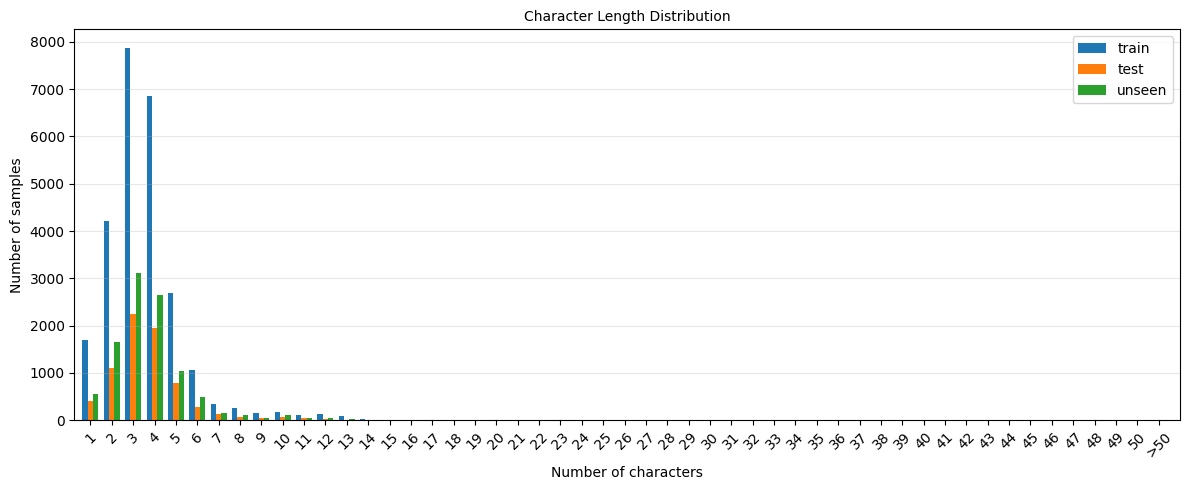

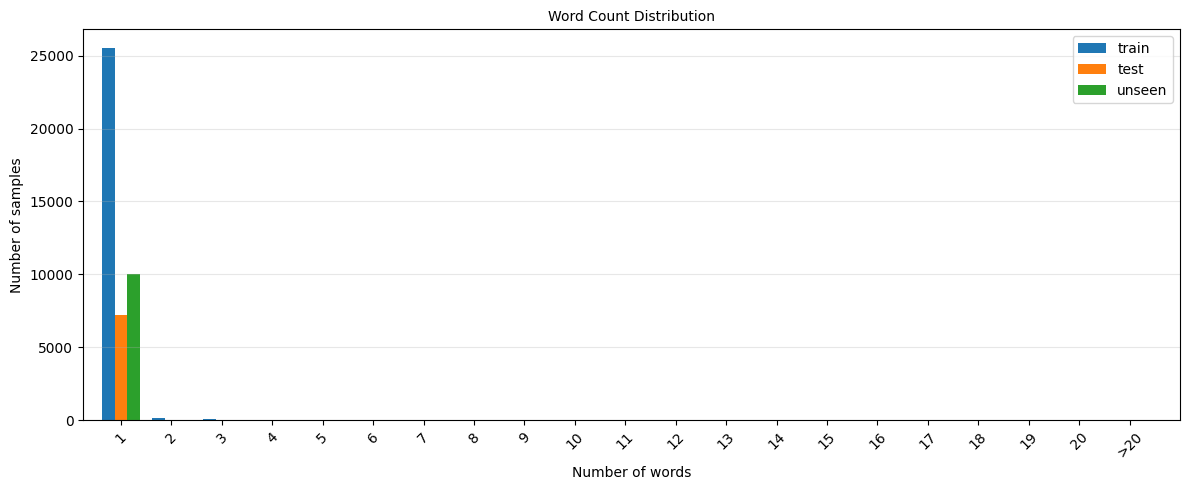


====== Split: Train ======
Original Width:
  samples   : 25776
  min / max : 2 / 3979
  mean ± std: 81.99 ± 111.85
  median    : 47.0
  Q1 / Q3   : 26.00 / 92.00
  P10–P90   : [16.00, 182.00]
  IQR range : [2.00, 191.00]
  CV        : 1.364

Original Height:
  samples   : 25776
  min / max : 2 / 1418
  mean ± std: 45.08 ± 55.42
  median    : 27.0
  Q1 / Q3   : 16.00 / 52.00
  P10–P90   : [11.00, 96.00]
  IQR range : [2.00, 106.00]
  CV        : 1.229


====== Split: Test ======
Original Width:
  samples   : 7201
  min / max : 3 / 2194
  mean ± std: 78.50 ± 109.37
  median    : 47.0
  Q1 / Q3   : 26.00 / 89.00
  P10–P90   : [17.00, 164.00]
  IQR range : [3.00, 183.50]
  CV        : 1.393

Original Height:
  samples   : 7201
  min / max : 4 / 1062
  mean ± std: 42.57 ± 55.26
  median    : 26.0
  Q1 / Q3   : 16.00 / 47.00
  P10–P90   : [11.00, 87.00]
  IQR range : [4.00, 93.50]
  CV        : 1.298


====== Split: Unseen ======
Original Width:
  samples   : 10068
  min / max : 3 / 3935
  

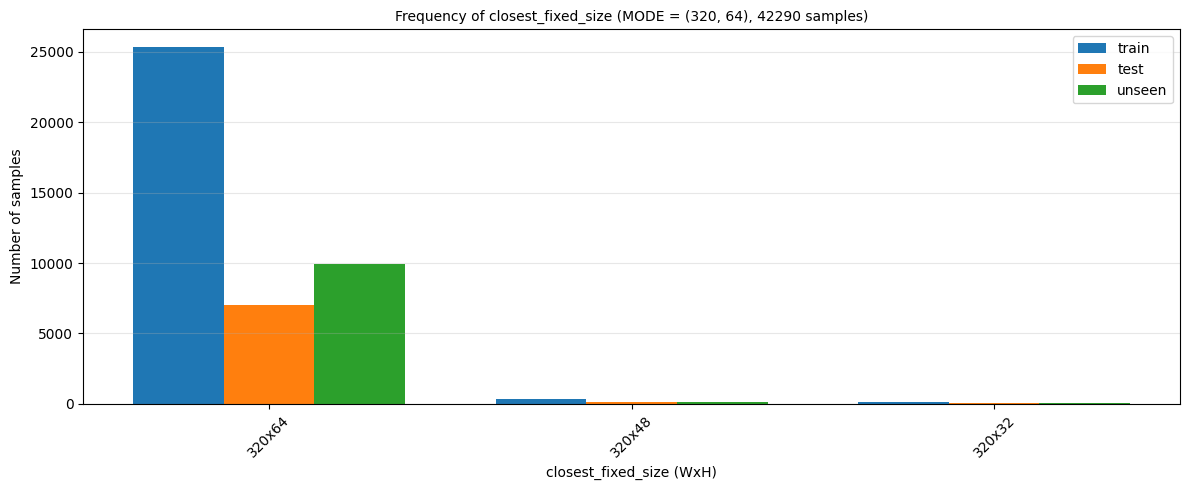

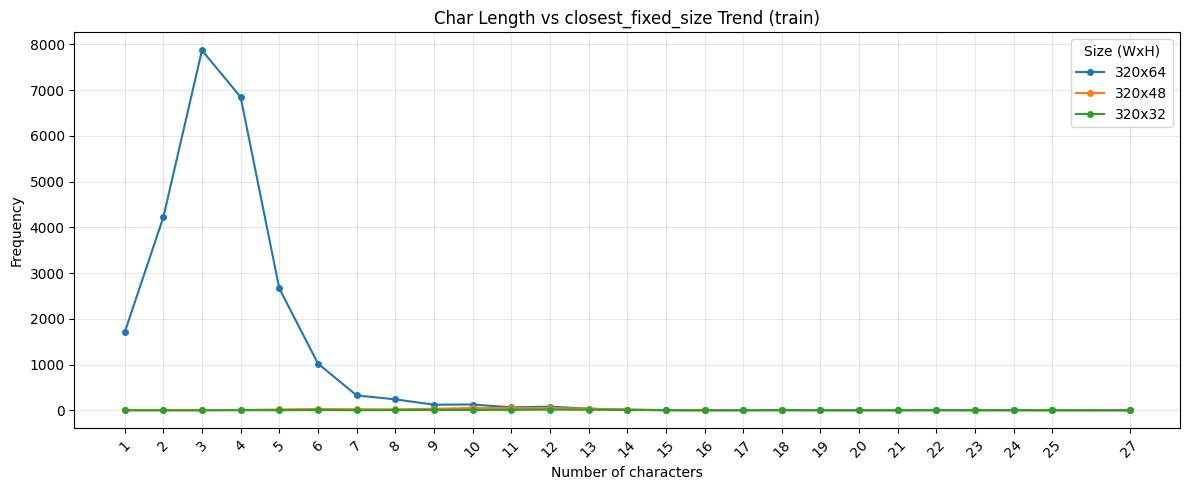

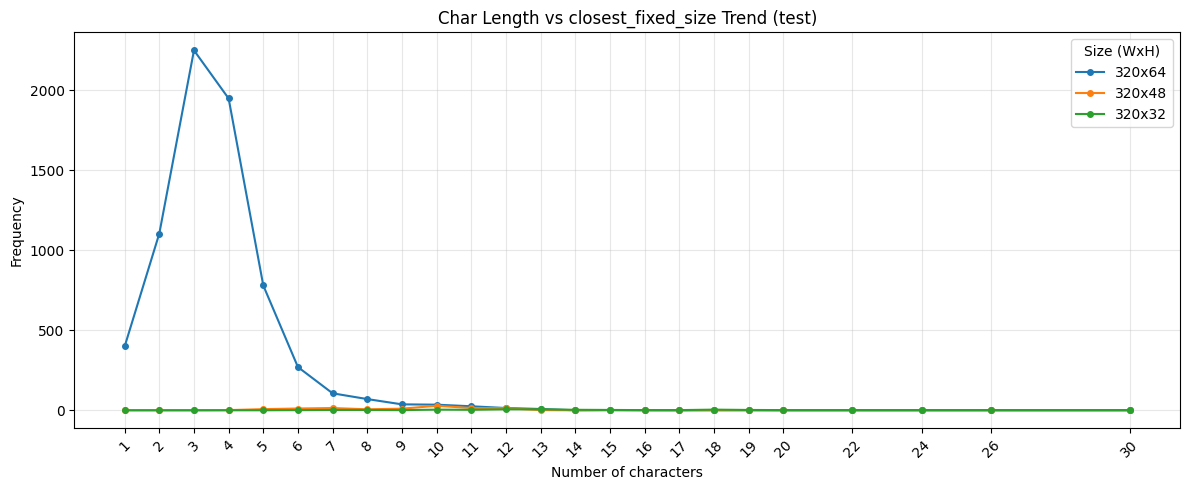

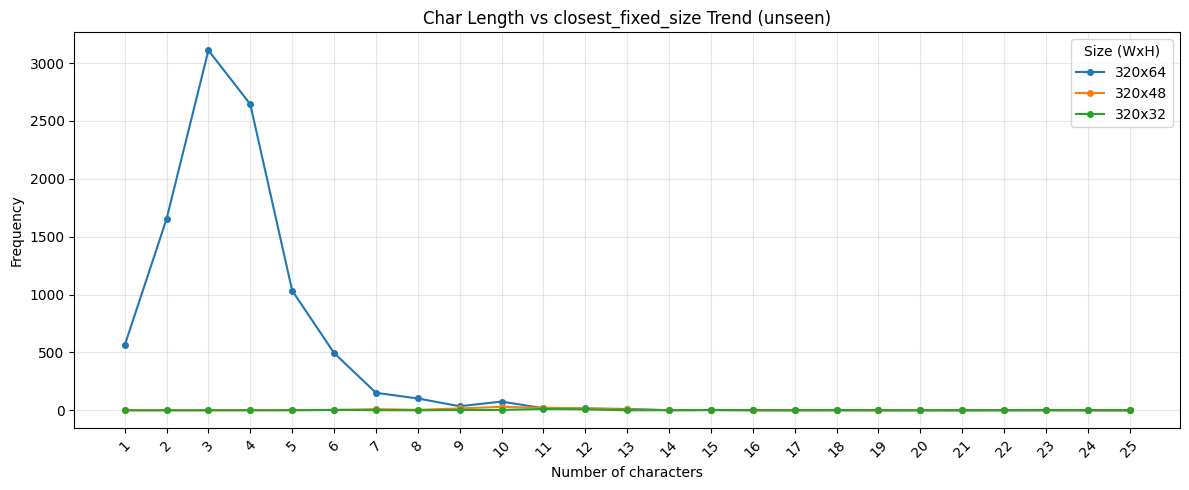

In [81]:
filter_and_plot_across_splits(
	results_dict=data_statistic,
	keywords=["word"])

## textline

===== Train =====
     <= 25 chars:  82.35% - 5739 samples 
      > 25 chars:  17.65% - 1230 samples 
    Q1 / Q2 / Q3: 9.0 / 16.0 / 22.0
       IQR range: [3.0, 41.5]
       Min / Max: 3 / 119
    ELR (P5–P95): [6.0, 39.0] chars
     Central 80%: [7.0, 32.0] chars
  Length entropy: 5.089
 Long-tail (>Q3): 23.62%
  Mode dominance: 7.52%

===== Test =====
     <= 25 chars:  80.64% - 1308 samples 
      > 25 chars:  19.36% - 314 samples 
    Q1 / Q2 / Q3: 11.0 / 16.0 / 23.0
       IQR range: [3.0, 41.0]
       Min / Max: 3 / 85
    ELR (P5–P95): [6.0, 40.0] chars
     Central 80%: [8.0, 32.0] chars
  Length entropy: 5.136
 Long-tail (>Q3): 24.17%
  Mode dominance: 5.86%

===== Unseen =====
     <= 25 chars:  81.23% - 1982 samples 
      > 25 chars:  18.77% - 458 samples 
    Q1 / Q2 / Q3: 10.0 / 16.0 / 23.0
       IQR range: [3.0, 42.5]
       Min / Max: 3 / 121
    ELR (P5–P95): [7.0, 39.0] chars
     Central 80%: [8.0, 32.0] chars
  Length entropy: 5.096
 Long-tail (>Q3): 23.44%
  Mode

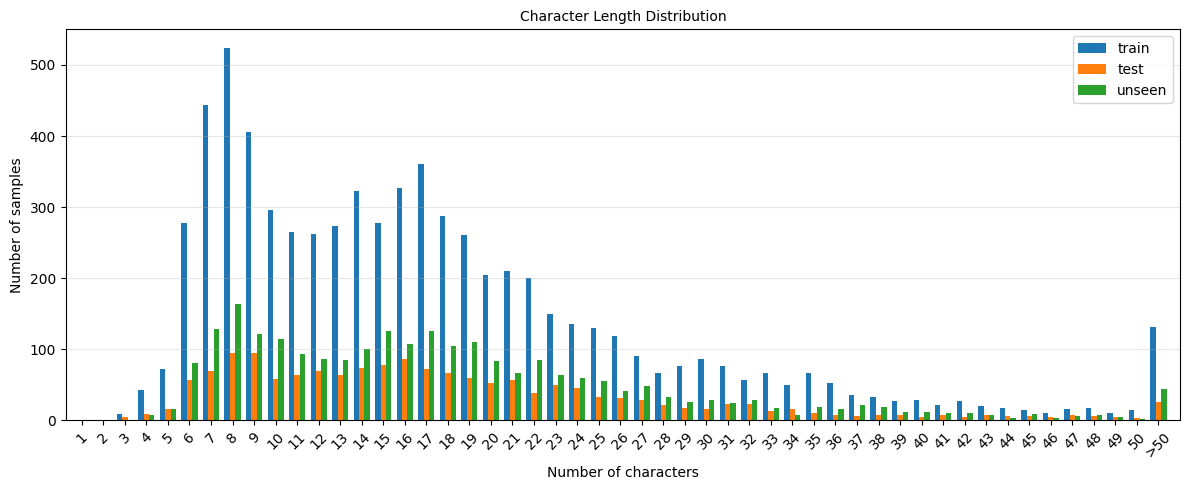

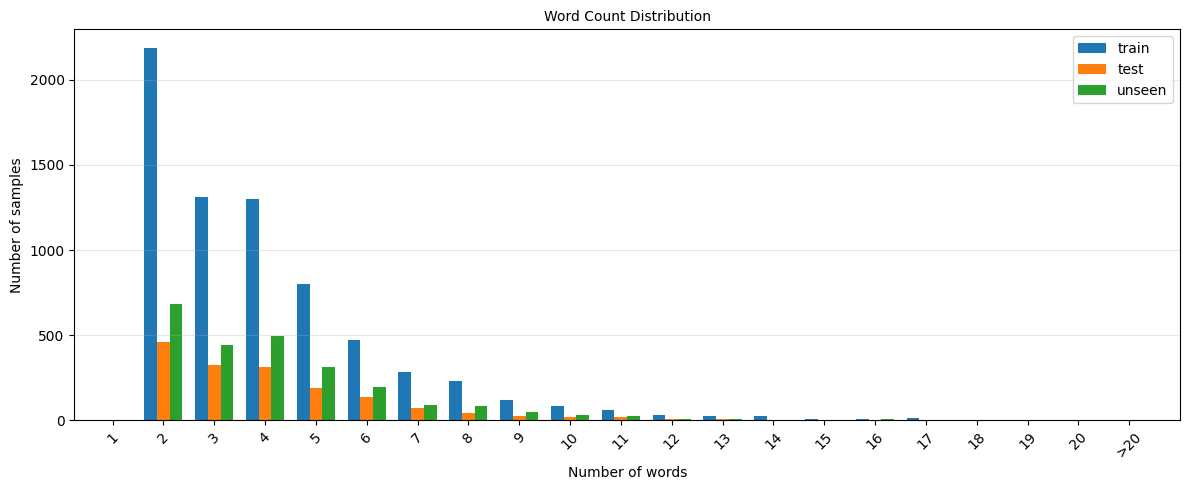


====== Split: Train ======
Original Width:
  samples   : 6969
  min / max : 12 / 4530
  mean ± std: 311.85 ± 324.07
  median    : 212.0
  Q1 / Q3   : 127.00 / 369.00
  P10–P90   : [76.00, 659.00]
  IQR range : [12.00, 732.00]
  CV        : 1.039

Original Height:
  samples   : 6969
  min / max : 5 / 887
  mean ± std: 51.39 ± 55.19
  median    : 34.0
  Q1 / Q3   : 21.00 / 60.00
  P10–P90   : [15.00, 106.00]
  IQR range : [5.00, 118.50]
  CV        : 1.074


====== Split: Test ======
Original Width:
  samples   : 1622
  min / max : 29 / 2798
  mean ± std: 298.83 ± 276.84
  median    : 210.0
  Q1 / Q3   : 132.00 / 368.50
  P10–P90   : [85.00, 612.50]
  IQR range : [29.00, 723.25]
  CV        : 0.926

Original Height:
  samples   : 1622
  min / max : 6 / 1060
  mean ± std: 47.27 ± 51.84
  median    : 32.0
  Q1 / Q3   : 20.00 / 56.00
  P10–P90   : [14.00, 92.00]
  IQR range : [6.00, 110.00]
  CV        : 1.097


====== Split: Unseen ======
Original Width:
  samples   : 2440
  min / max : 1

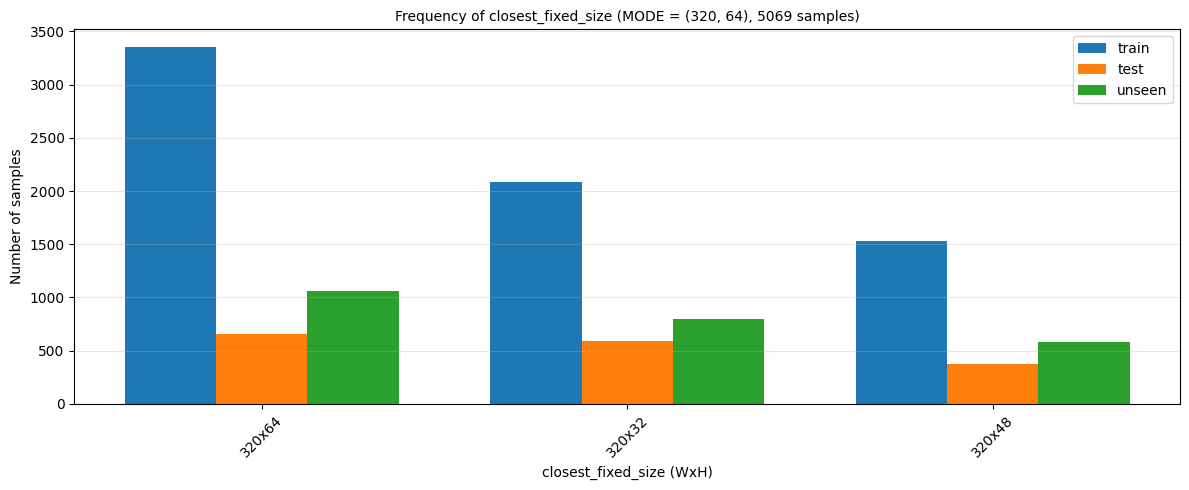

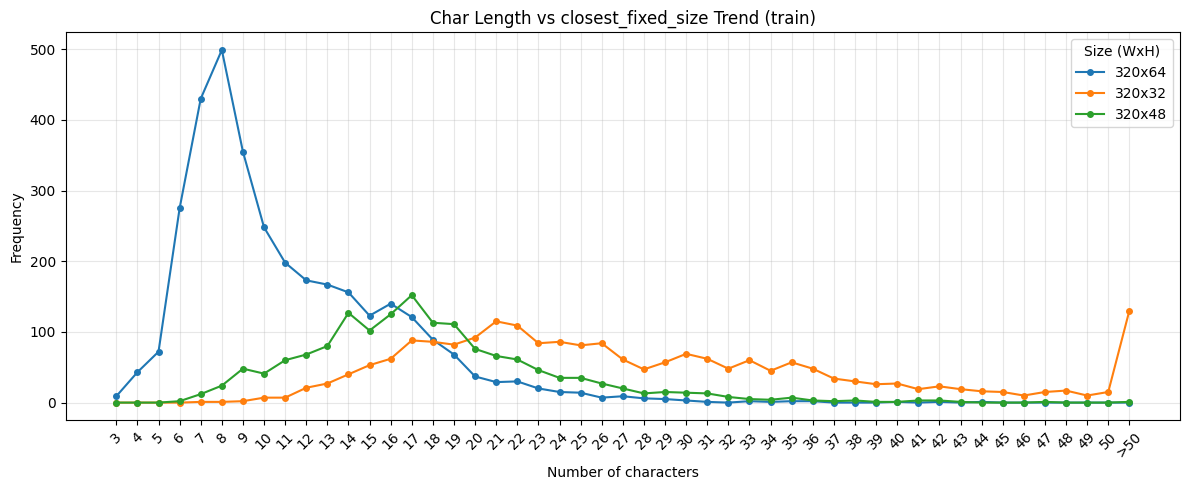

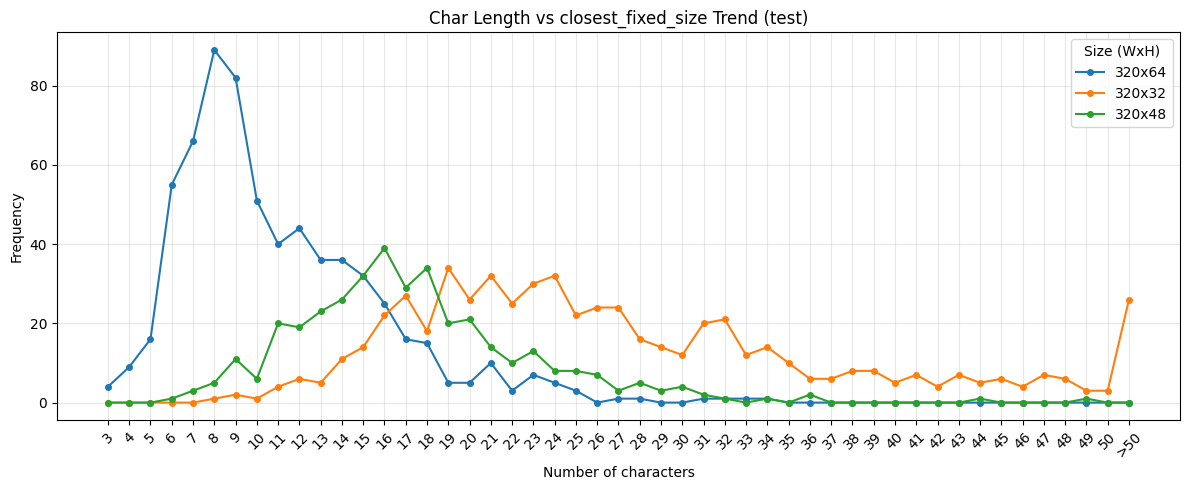

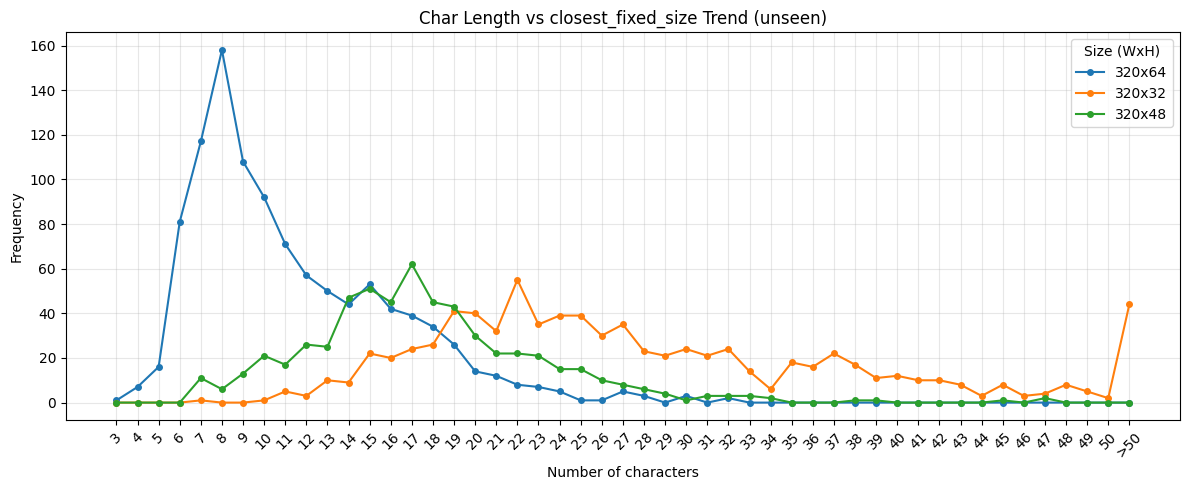

In [82]:
filter_and_plot_across_splits(
	results_dict=data_statistic,
	keywords=["textline"])

## textline (40+ chars)

===== Train =====
     <= 25 chars:    0.0% - 0 samples 
      > 25 chars:  100.0% - 329 samples 
    Q1 / Q2 / Q3: 43.0 / 48.0 / 57.0
       IQR range: [40.0, 78.0]
       Min / Max: 40 / 119
    ELR (P5–P95): [40.0, 75.6] chars
     Central 80%: [41.0, 65.0] chars
  Length entropy: 4.880
 Long-tail (>Q3): 24.62%
  Mode dominance: 8.81%

===== Test =====
     <= 25 chars:    0.0% - 0 samples 
      > 25 chars:  100.0% - 85 samples 
    Q1 / Q2 / Q3: 43.0 / 47.0 / 52.0
       IQR range: [40.0, 65.5]
       Min / Max: 40 / 85
    ELR (P5–P95): [40.2, 64.6] chars
     Central 80%: [41.0, 60.0] chars
  Length entropy: 4.393
 Long-tail (>Q3): 24.71%
  Mode dominance: 8.24%

===== Unseen =====
     <= 25 chars:    0.0% - 0 samples 
      > 25 chars:  100.0% - 120 samples 
    Q1 / Q2 / Q3: 42.0 / 47.0 / 54.0
       IQR range: [40.0, 72.0]
       Min / Max: 40 / 121
    ELR (P5–P95): [40.0, 87.0] chars
     Central 80%: [40.9, 73.0] chars
  Length entropy: 4.529
 Long-tail (>Q3): 24.17%
  Mo

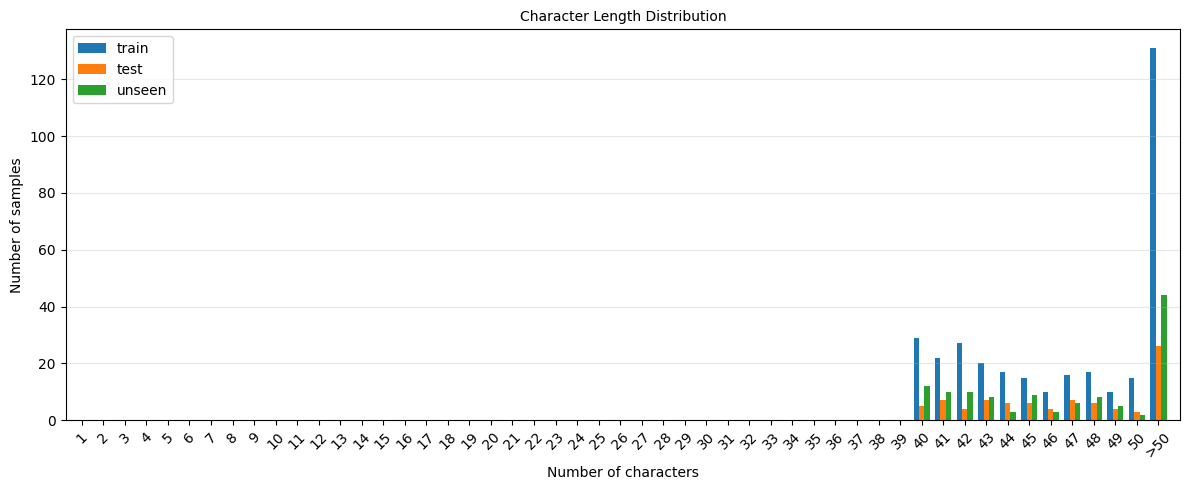

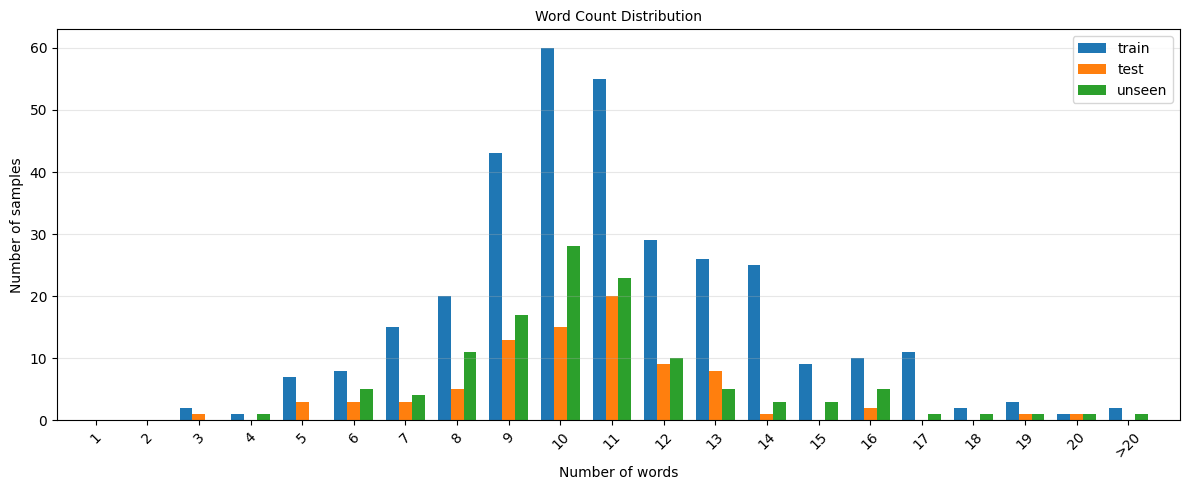


====== Split: Train ======
Original Width:
  samples   : 329
  min / max : 108 / 3839
  mean ± std: 618.66 ± 494.62
  median    : 448.0
  Q1 / Q3   : 327.00 / 705.00
  P10–P90   : [238.00, 1246.20]
  IQR range : [108.00, 1272.00]
  CV        : 0.799

Original Height:
  samples   : 329
  min / max : 10 / 182
  mean ± std: 39.68 ± 33.58
  median    : 27.0
  Q1 / Q3   : 20.00 / 43.00
  P10–P90   : [15.00, 91.00]
  IQR range : [10.00, 77.50]
  CV        : 0.846


====== Split: Test ======
Original Width:
  samples   : 85
  min / max : 182 / 1811
  mean ± std: 539.42 ± 349.22
  median    : 422.0
  Q1 / Q3   : 270.00 / 695.00
  P10–P90   : [228.40, 1004.00]
  IQR range : [182.00, 1332.50]
  CV        : 0.647

Original Height:
  samples   : 85
  min / max : 12 / 196
  mean ± std: 34.89 ± 27.36
  median    : 25.0
  Q1 / Q3   : 17.00 / 46.00
  P10–P90   : [14.00, 64.80]
  IQR range : [12.00, 89.50]
  CV        : 0.784


====== Split: Unseen ======
Original Width:
  samples   : 120
  min / max 

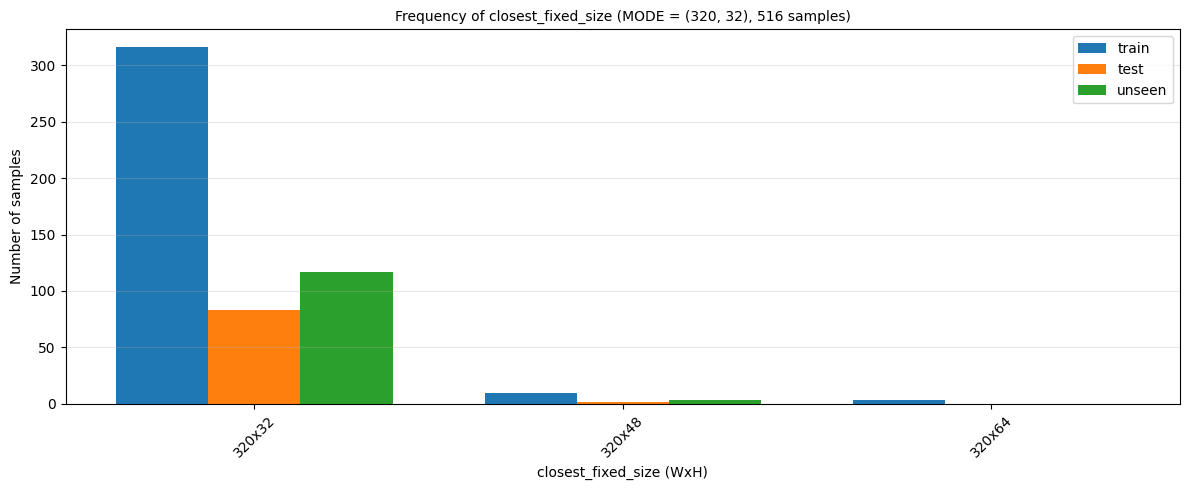

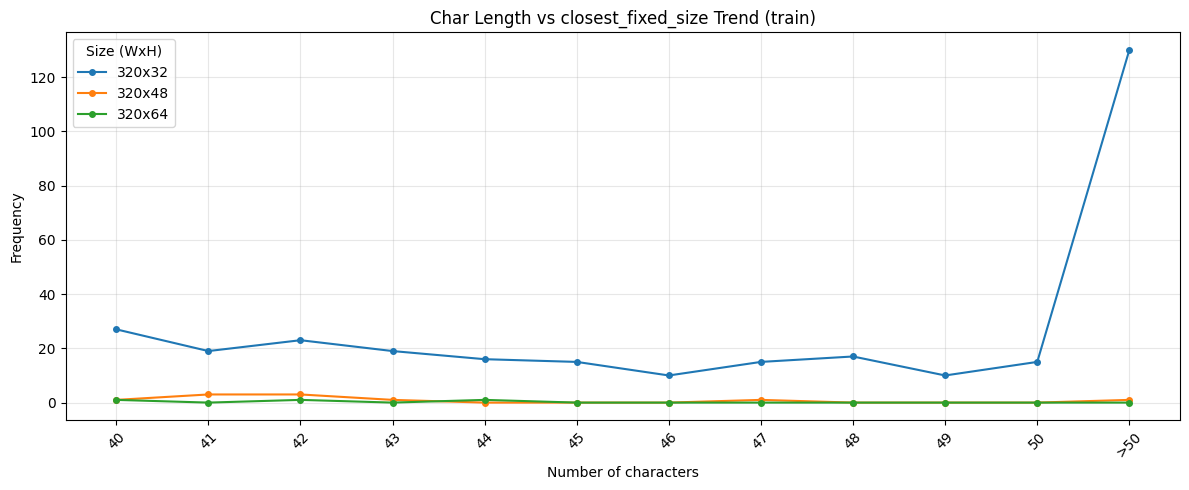

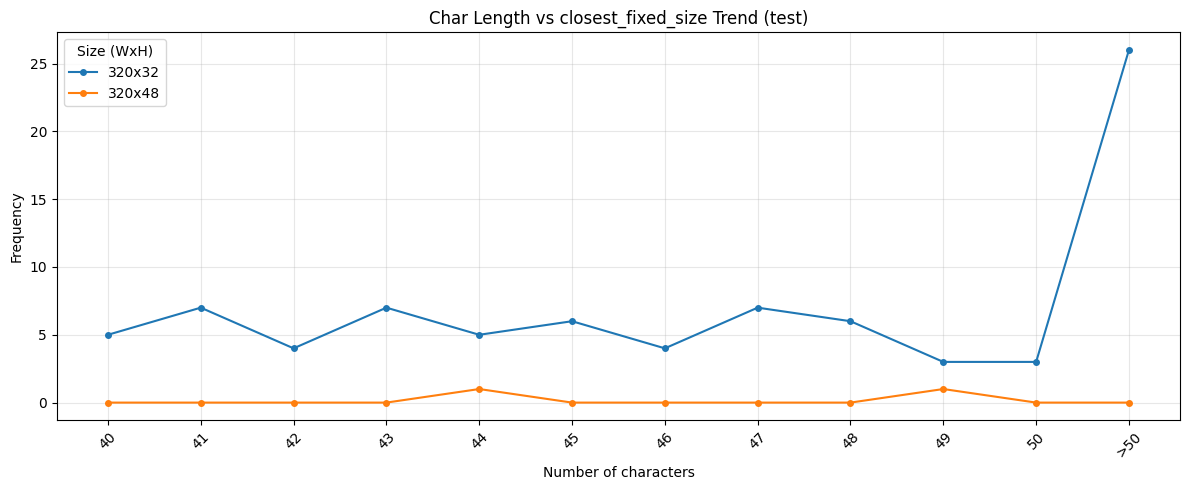

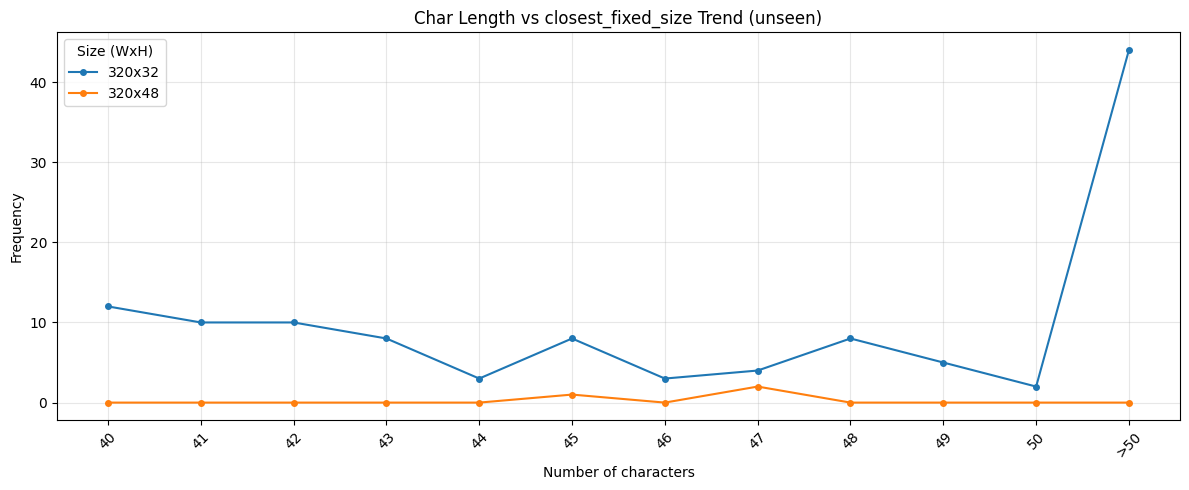

In [83]:
filter_and_plot_across_splits(
	results_dict=data_statistic,
	keywords=["textline"],
 	min_chars=40)

## combination

===== Train =====
     <= 25 chars:  96.24% - 31514 samples 
      > 25 chars:   3.76% - 1231 samples 
    Q1 / Q2 / Q3: 3.0 / 4.0 / 6.0
       IQR range: [1.0, 10.5]
       Min / Max: 1 / 119
    ELR (P5–P95): [1.0, 23.0] chars
     Central 80%: [2.0, 16.0] chars
  Length entropy: 3.723
 Long-tail (>Q3): 24.30%
  Mode dominance: 24.06%

===== Test =====
     <= 25 chars:  96.42% - 8507 samples 
      > 25 chars:   3.58% - 316 samples 
    Q1 / Q2 / Q3: 3.0 / 4.0 / 6.0
       IQR range: [1.0, 10.5]
       Min / Max: 1 / 85
    ELR (P5–P95): [2.0, 23.0] chars
     Central 80%: [2.0, 16.0] chars
  Length entropy: 3.613
 Long-tail (>Q3): 22.27%
  Mode dominance: 25.55%

===== Unseen =====
     <= 25 chars:  96.34% - 12050 samples 
      > 25 chars:   3.66% - 458 samples 
    Q1 / Q2 / Q3: 3.0 / 4.0 / 6.0
       IQR range: [1.0, 10.5]
       Min / Max: 1 / 121
    ELR (P5–P95): [2.0, 23.0] chars
     Central 80%: [2.0, 16.0] chars
  Length entropy: 3.671
 Long-tail (>Q3): 23.18%
  Mode dom

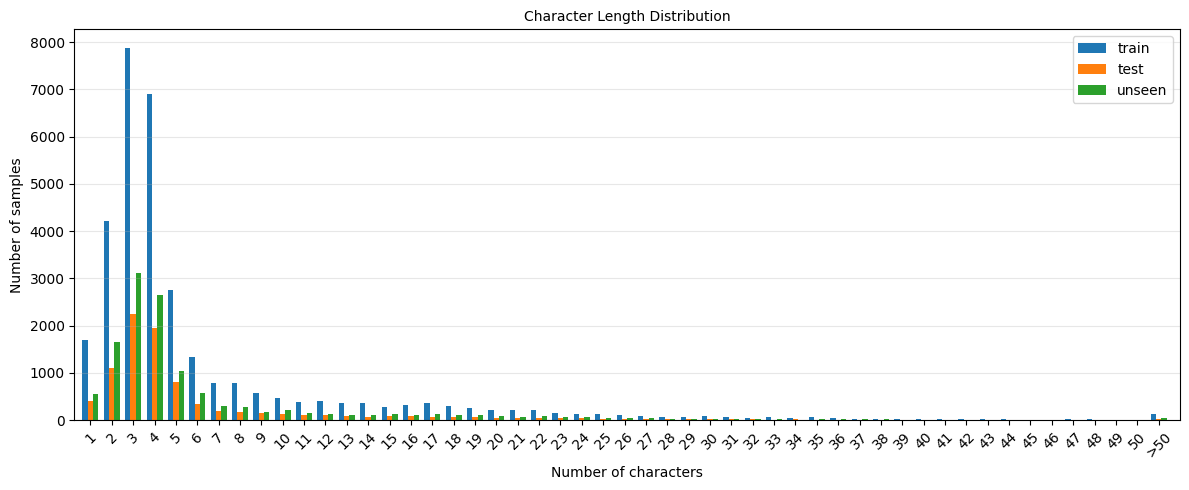

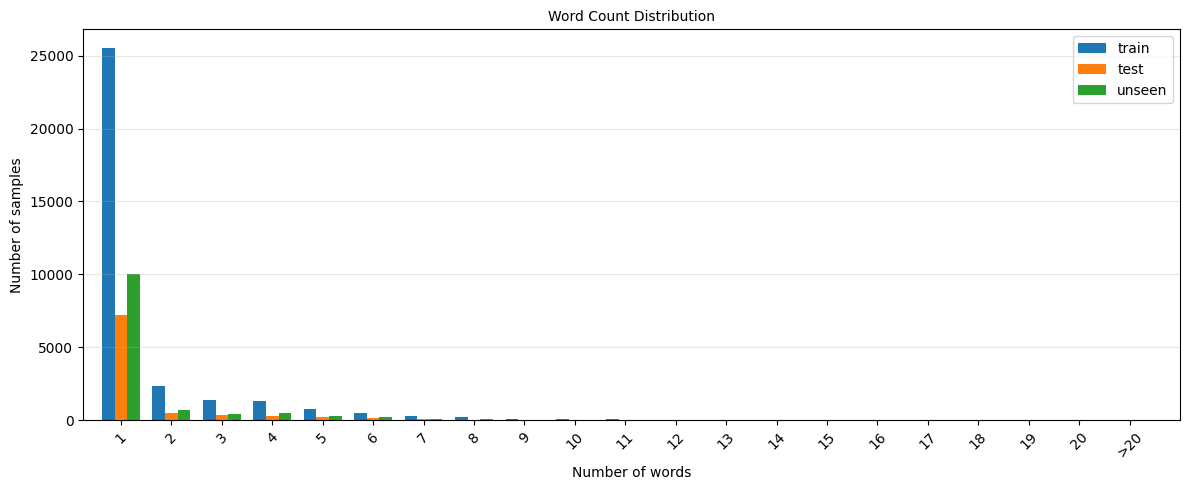


====== Split: Train ======
Original Width:
  samples   : 32745
  min / max : 2 / 4530
  mean ± std: 130.91 ± 202.61
  median    : 63.0
  Q1 / Q3   : 30.00 / 149.00
  P10–P90   : [17.00, 307.00]
  IQR range : [2.00, 327.50]
  CV        : 1.548

Original Height:
  samples   : 32745
  min / max : 2 / 1418
  mean ± std: 46.42 ± 55.43
  median    : 29.0
  Q1 / Q3   : 17.00 / 54.00
  P10–P90   : [12.00, 98.00]
  IQR range : [2.00, 109.50]
  CV        : 1.194


====== Split: Test ======
Original Width:
  samples   : 8823
  min / max : 3 / 2798
  mean ± std: 119.00 ± 176.46
  median    : 60.0
  Q1 / Q3   : 30.00 / 134.00
  P10–P90   : [18.00, 276.60]
  IQR range : [3.00, 290.00]
  CV        : 1.483

Original Height:
  samples   : 8823
  min / max : 4 / 1062
  mean ± std: 43.44 ± 54.68
  median    : 27.0
  Q1 / Q3   : 17.00 / 49.00
  P10–P90   : [12.00, 88.00]
  IQR range : [4.00, 97.00]
  CV        : 1.259


====== Split: Unseen ======
Original Width:
  samples   : 12508
  min / max : 3 / 393

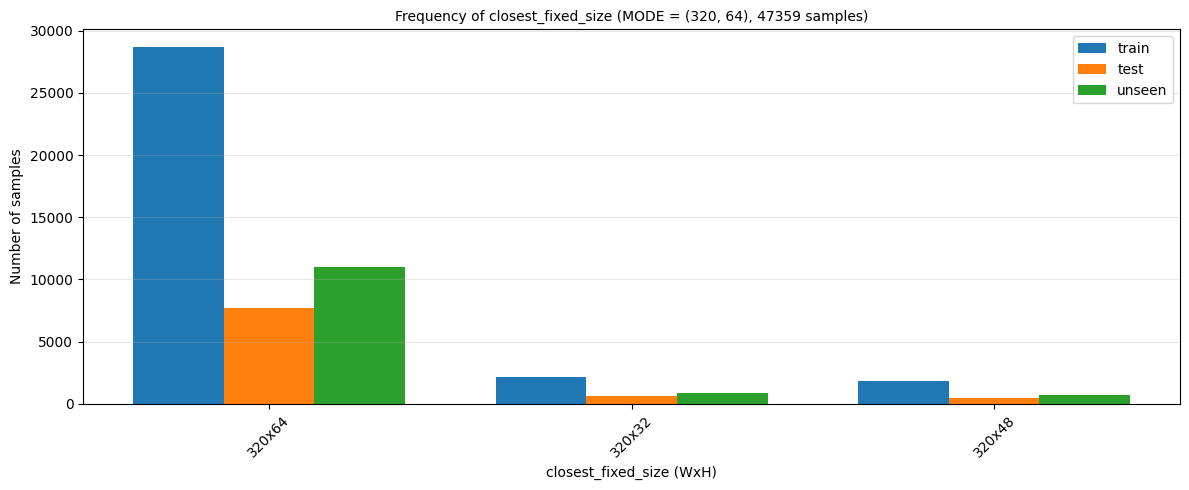

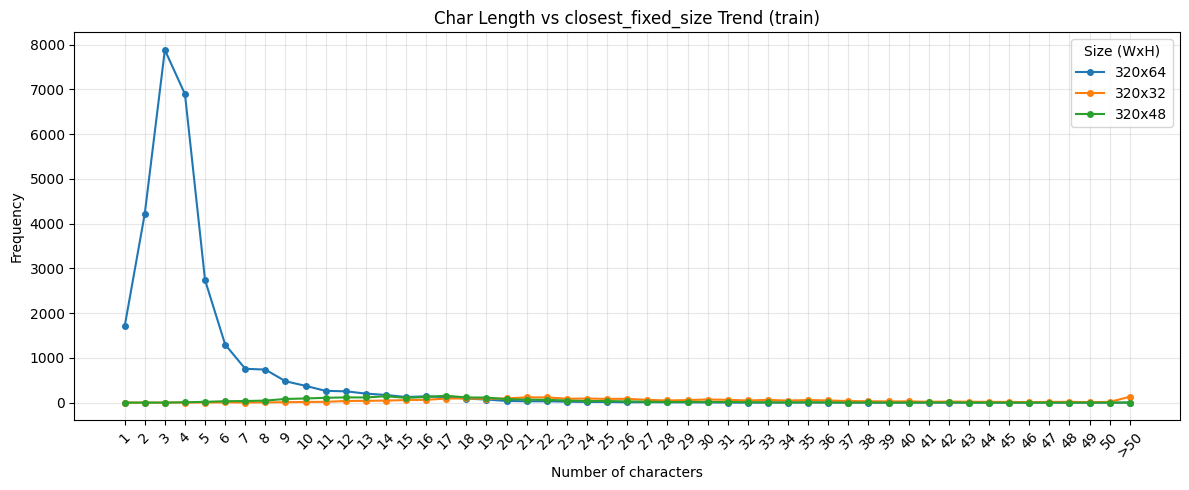

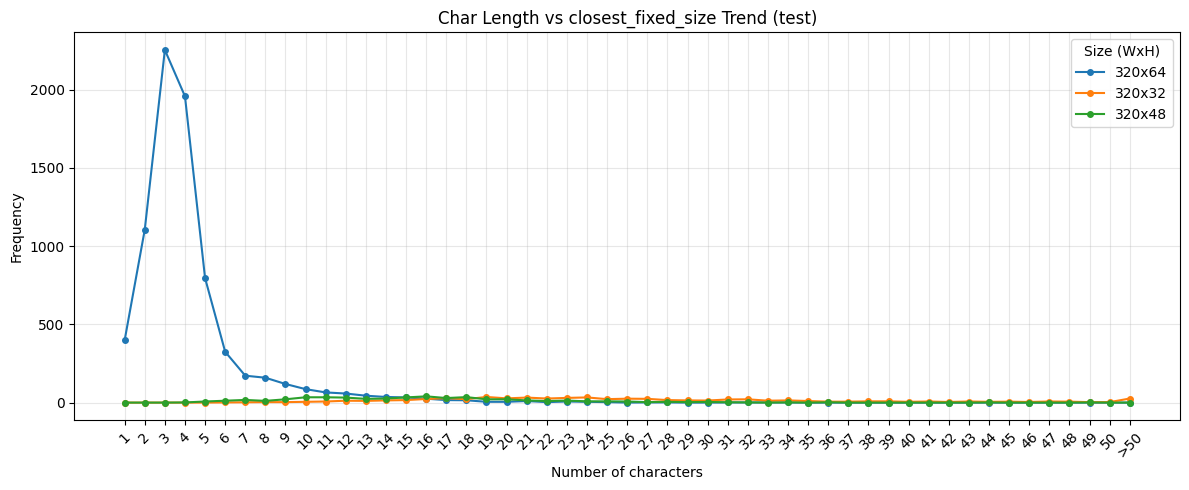

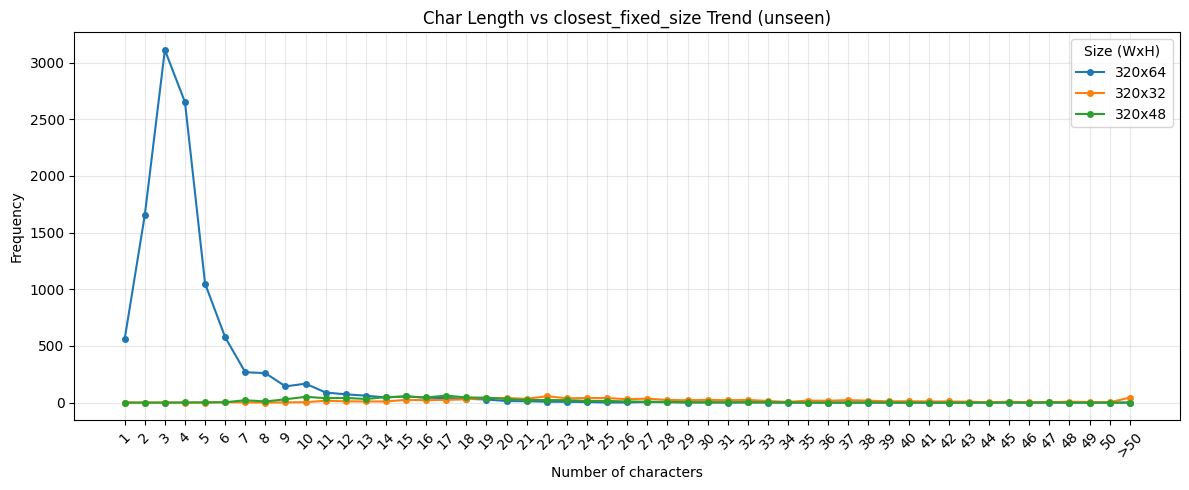

In [84]:
filter_and_plot_across_splits(
	results_dict=data_statistic,
	keywords=["word", "textline"])

## summary

| Dataset                 | Most Popular Size | Length Characteristics |
|-------------------------|-------------------| ------------------- |
| Word                    | 320 × 64          | 90% 1–7 chars, low entropy, high concentration |
| Text line               | 320 × 64          | 90% 6–40 chars, high entropy, balanced tail    |
| Text line (≥ 40 chars)  | **320 × 32**      | 90% 40–75+ chars, width-limited, dense layout  |
| Word & Text line        | 320 × 64          | 90% 1–23 chars, medium entropy                 |

**Word dataset** <br>
* Most samples are very short words.
* Text lengths are not diverse.
* Many samples have the same or very similar length, and the model keeps seeing the same kind of text again and again.

**Text line dataset** <br>
* This dataset contains short, medium, and long text lines, and the lengths are well spread out.
* Text lengths are highly diverse.
* Long text lines are not rare.
* The model sees many different text layouts during training.

**Text line 40+ chars dataset**
* Almost all samples are very long text lines, width-limited.
* Characters are squeezed horizontally.
* Text lines ≥ 40 chars and fixed width (320 px), so characters per unit width is high (dense). Equivalently, px/char is low

**Word & Text line dataset** <br>
* Distribution is pulled heavily toward words.
* The dataset is dominated by short words and moderately long text.
* Long text exists but is uncommon

## experiment

**Background**  
* The OCR model was trained with multi-scale strategy (PaddleOCR’s default configuration). During training, the image width is fixed at 320 pixels, while the height changes between 32, 48, and 64. This helps the model see text at different sizes and shapes.

**Hypothesis**  
* We hypothesize that an inference strategy which minimizes geometric distortion will yield higher recognition accuracy than standard fixed-shape methods.

**Reasoning**  
* Most 40+ text lines map to the input shape of (320, 32). Because the inference width is fixed at 320, minimizing distortion for long text requires a proportionally smaller height to match the horizontal compression. Our data analysis confirms that this specific shape accounts for 96.63% of the long-text samples.
* Resizing all images to one fixed shape (e.g., 320×48) when inference can stretch or squash characters. This may be harmful for Vietnamese text, where diacritics are very important.
* We expect that an auto inference strategy, which chooses the closest shape based on the original aspect ratio, will keep the text more natural and reduce distortion, especially for long text lines.

**Goal**  
* Compare the **auto** inference strategy with fixed shapes (e.g., 320×48, 320×64) to check whether preserving aspect ratio gives better accuracy on long Vietnamese text.
